In [1]:
!pip install medmnist seaborn ncps scipy pillow Cmake nes-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 838.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (5

# Imports

In [2]:
import os
import imageio
import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import keras.layers
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet


import random as rn
rn.seed(30)
np.random.seed(30)
tf.random.set_seed

from ncps import wirings
from ncps.wirings import AutoNCP
from ncps.tf import LTC

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import seaborn as sns


# Plot accuracy score and loss from training history

In [3]:
def plot(history):
    %config InlineBackend.figure_format = 'retina'
    plt.rcParams['figure.figsize'] = 8, 5
    plt.rcParams['font.size'] = 12
    plt.rcParams['savefig.format'] = 'pdf'
    sns.set(style='darkgrid', palette='deep')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['sparse_categorical_accuracy'])
    axes[1].plot(history.history['val_sparse_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_sparse_categorical_accuracy'])

# First idea - just to change LSTM to LTC and compare results

In [ ]:
class CNN_LTC():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 30
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=2, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=4,verbose=1)
        self.callbacks_list = [checkpoint, LR, earlystop]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,2)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LTC(self.wiring, return_sequences=False))
        #model.add(Dropout(dropout))

        #model.add(Dense(dense_neurons,activation='relu'))
        #model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [ ]:
cnn_ltc = CNN_LTC()
cnn_ltc.init()
cnn_ltc.create_data()

100%|██████████| 29299364/29299364 [00:02<00:00, 10763034.08it/s]


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
cnn_ltc_model = cnn_ltc.define_model(ncp_neurons=21,dense_neurons=32,dropout=0.1)
cnn_ltc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 28, 28, 28, 16)    160       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 28, 28, 28, 16)    64        
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 28, 14, 14, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 28, 14, 14, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 28, 14, 14, 32)    1

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc.train_model(cnn_ltc_model)

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 0.5657 - sparse_categorical_accuracy: 0.7453
Epoch 1: val_loss improved from inf to 0.58929, saving model to model_2024-03-2912_39_24.391174/first model
37/37 [==============================] - 39s 546ms/step - loss: 0.5657 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.5893 - val_sparse_categorical_accuracy: 0.7455 - lr: 0.0100
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 0.5563 - sparse_categorical_accuracy: 0.7453
Epoch 2: val_loss improved from 0.58929 to 0.57586, saving model to model_2024-03-2912_39_24.391174/first model
37/37 [==============================] - 16s 446ms/step - loss: 0.5563 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.5759 - val_sparse_categorical_accuracy: 0.7455 - lr: 0.0100
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 0.5438 - sparse_categorical_accuracy: 0.7453
Epoch 3: val_loss did not improve from 0.57586
37/37 [=====================

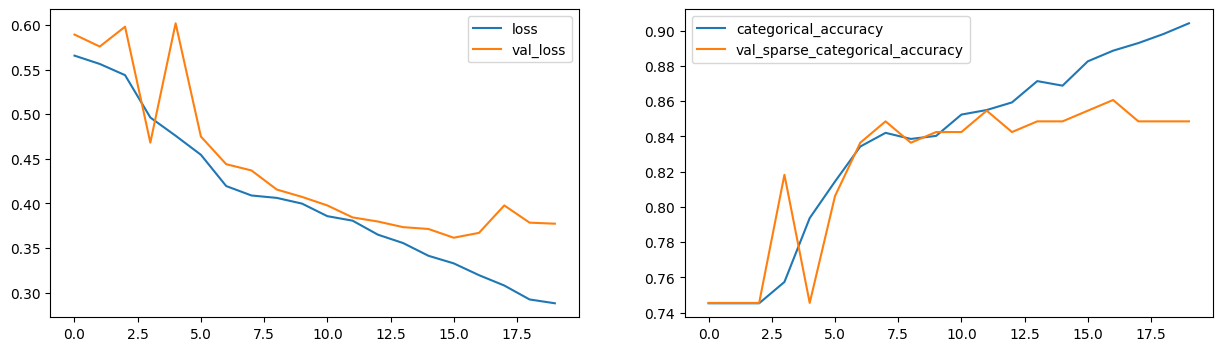

In [ ]:
plot(model)

In [ ]:
cnn_ltc_model.evaluate(cnn_ltc.x_test, cnn_ltc.y_test, batch_size = 32)

10/10 [==============================] - 1s 64ms/step - loss: 0.3804 - sparse_categorical_accuracy: 0.8516


[0.380372554063797, 0.85161292552948]

##Lets evaluate this model on another dataset - multiclass classification

In [ ]:
class CNN_LTC_2():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 50
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.00001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [checkpoint, LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))


        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        #model.add(Dense(dense_neurons,activation='relu'))
        #model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [ ]:
cnn_ltc_2 = CNN_LTC_2()
cnn_ltc_2.init()
cnn_ltc_2.create_data()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [ ]:
cnn_ltc_2_model = cnn_ltc_2.define_model(ncp_neurons=21,dense_neurons=32,dropout=0.1)
cnn_ltc_2_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_273 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_274 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_275 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_276 (Time  (None, 28, 14, 14, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_277 (Time  (None, 28, 14, 14, 32)  

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_2.train_model(cnn_ltc_2_model)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.3015 - sparse_categorical_accuracy: 0.2101
Epoch 1: val_loss improved from inf to 2.44653, saving model to model_2024-03-2914_02_04.618446/first model
16/16 [==============================] - 26s 845ms/step - loss: 2.3015 - sparse_categorical_accuracy: 0.2101 - val_loss: 2.4465 - val_sparse_categorical_accuracy: 0.0994 - lr: 0.0100
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.0000 - sparse_categorical_accuracy: 0.4016
Epoch 2: val_loss did not improve from 2.44653
16/16 [==============================] - 5s 301ms/step - loss: 2.0000 - sparse_categorical_accuracy: 0.4016 - val_loss: 2.6469 - val_sparse_categorical_accuracy: 0.0745 - lr: 0.0100
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.5823 - sparse_categorical_accuracy: 0.4717
Epoch 3: val_loss did not improve from 2.44653
16/16 [==============================] - 5s 298ms/step - loss: 1.5823 - sparse_categorical_acc

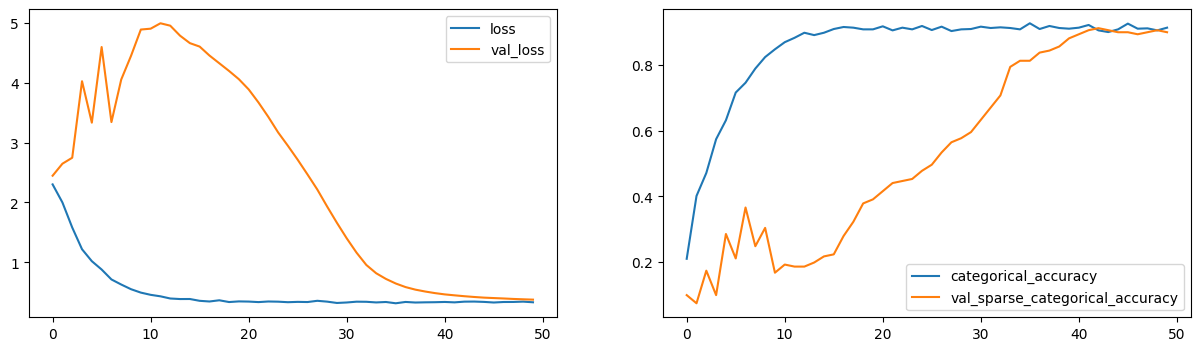

In [ ]:
plot(model)

In [ ]:
cnn_ltc_2_model.evaluate(cnn_ltc_2.x_test, cnn_ltc_2.y_test, batch_size = 64)

10/10 [==============================] - 1s 70ms/step - loss: 0.7489 - sparse_categorical_accuracy: 0.7705


[0.7488710284233093, 0.7704917788505554]

# Another experiment - lets make start LR 1e-4 and add more dropout and increase number of neurons

In [ ]:
class CNN_LTC_3():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 50
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.00001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [checkpoint, LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        #model.add(Dense(dense_neurons,activation='relu'))
        #model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc_3 = CNN_LTC_3()
cnn_ltc_3.init()
cnn_ltc_3.create_data()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [ ]:
cnn_ltc_3_model = cnn_ltc_3.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.1)
cnn_ltc_3_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_299 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_300 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_301 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_302 (Time  (None, 28, 14, 14, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_303 (Time  (None, 28, 14, 14, 32)  

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_3.train_model(cnn_ltc_3_model)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.3654 - sparse_categorical_accuracy: 0.1215
Epoch 1: val_loss improved from inf to 2.44738, saving model to model_2024-03-2914_16_54.725772/first model
16/16 [==============================] - 24s 834ms/step - loss: 2.3654 - sparse_categorical_accuracy: 0.1215 - val_loss: 2.4474 - val_sparse_categorical_accuracy: 0.0932 - lr: 1.0000e-04
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.2986 - sparse_categorical_accuracy: 0.1648
Epoch 2: val_loss did not improve from 2.44738
16/16 [==============================] - 6s 366ms/step - loss: 2.2986 - sparse_categorical_accuracy: 0.1648 - val_loss: 2.4562 - val_sparse_categorical_accuracy: 0.0932 - lr: 1.0000e-04
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 2.2468 - sparse_categorical_accuracy: 0.2091
Epoch 3: val_loss did not improve from 2.44738
16/16 [==============================] - 5s 304ms/step - loss: 2.2468 - sparse_categor

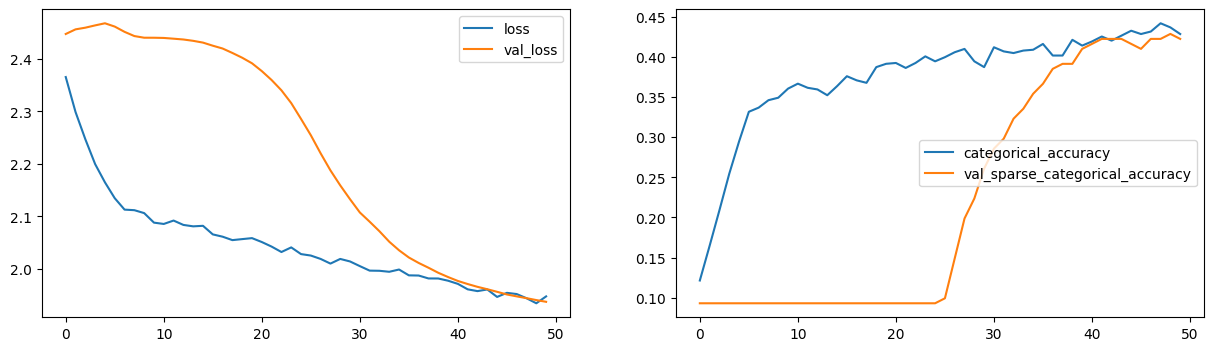

In [ ]:
plot(model)

In [ ]:
cnn_ltc_3_model.evaluate(cnn_ltc_3.x_test, cnn_ltc_3.y_test, batch_size = 64)

10/10 [==============================] - 0s 38ms/step - loss: 1.9796 - sparse_categorical_accuracy: 0.4115


[1.979566216468811, 0.41147541999816895]

## We can see that model is underfitting - lets remove the dropout

In [ ]:
class CNN_LTC_4():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 50
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        #model.add(Dense(dense_neurons,activation='relu'))
        #model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc_4 = CNN_LTC_4()
cnn_ltc_4.init()
cnn_ltc_4.create_data()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [ ]:
cnn_ltc_4_model = cnn_ltc_4.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.1)
cnn_ltc_4_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_312 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_313 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_314 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_315 (Time  (None, 28, 14, 14, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_316 (Time  (None, 28, 14, 14, 32)  

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_4.train_model(cnn_ltc_4_model)

Epoch 1/50
16/16 [==============================] - 22s 516ms/step - loss: 2.1825 - sparse_categorical_accuracy: 0.2750 - val_loss: 2.4277 - val_sparse_categorical_accuracy: 0.0932 - lr: 0.0100
Epoch 2/50
16/16 [==============================] - 8s 452ms/step - loss: 1.6546 - sparse_categorical_accuracy: 0.4748 - val_loss: 3.4115 - val_sparse_categorical_accuracy: 0.0932 - lr: 0.0100
Epoch 3/50
16/16 [==============================] - 5s 284ms/step - loss: 1.2575 - sparse_categorical_accuracy: 0.5860 - val_loss: 4.7511 - val_sparse_categorical_accuracy: 0.0932 - lr: 0.0100
Epoch 4/50
16/16 [==============================] - 6s 360ms/step - loss: 1.1075 - sparse_categorical_accuracy: 0.6107 - val_loss: 4.1828 - val_sparse_categorical_accuracy: 0.1429 - lr: 0.0100
Epoch 5/50
16/16 [==============================] - 5s 287ms/step - loss: 0.9327 - sparse_categorical_accuracy: 0.6849 - val_loss: 3.4179 - val_sparse_categorical_accuracy: 0.1988 - lr: 0.0100
Epoch 6/50
16/16 [================

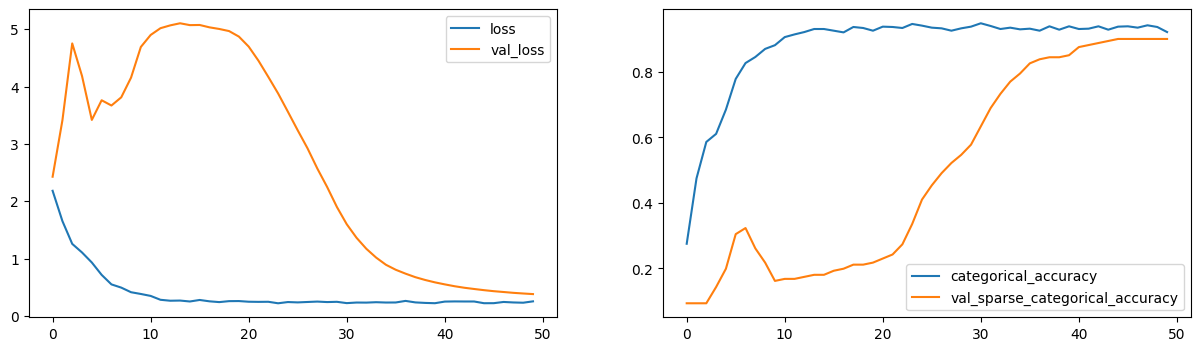

In [ ]:
plot(model)

In [ ]:
cnn_ltc_4_model.evaluate(cnn_ltc_4.x_test, cnn_ltc_4.y_test, batch_size = 64)

10/10 [==============================] - 1s 96ms/step - loss: 0.5651 - sparse_categorical_accuracy: 0.8230


[0.5650631189346313, 0.8229508399963379]

## As we can see - it is important to make reducing learning rate: if we make it high, the model is underfitting. Also, increasing number of neurons in LTC gave us +5% test accuracy

## Now lets try to increase to bear with overfitting since our test score is noticably lower, than train (and valid?)

In [ ]:
class CNN_LTC_5():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        #model.add(Dense(dense_neurons,activation='relu'))
        #model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc_5 = CNN_LTC_5()
cnn_ltc_5.init()
cnn_ltc_5.create_data()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [ ]:
cnn_ltc_5_model = cnn_ltc_5.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.2)
cnn_ltc_5_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_325 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_326 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_327 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_328 (Time  (None, 28, 14, 14, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_329 (Time  (None, 28, 14, 14, 32)  

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_5.train_model(cnn_ltc_5_model)

Epoch 1/60
16/16 [==============================] - 17s 402ms/step - loss: 2.1887 - sparse_categorical_accuracy: 0.2657 - val_loss: 2.4547 - val_sparse_categorical_accuracy: 0.0932 - lr: 0.0100
Epoch 2/60
16/16 [==============================] - 10s 617ms/step - loss: 1.7566 - sparse_categorical_accuracy: 0.4315 - val_loss: 2.7070 - val_sparse_categorical_accuracy: 0.0932 - lr: 0.0100
Epoch 3/60
16/16 [==============================] - 7s 414ms/step - loss: 1.2855 - sparse_categorical_accuracy: 0.5654 - val_loss: 3.7961 - val_sparse_categorical_accuracy: 0.0932 - lr: 0.0100
Epoch 4/60
16/16 [==============================] - 6s 363ms/step - loss: 1.0313 - sparse_categorical_accuracy: 0.6519 - val_loss: 3.8942 - val_sparse_categorical_accuracy: 0.1056 - lr: 0.0100
Epoch 5/60
16/16 [==============================] - 5s 310ms/step - loss: 0.9203 - sparse_categorical_accuracy: 0.6818 - val_loss: 3.6432 - val_sparse_categorical_accuracy: 0.2360 - lr: 0.0100
Epoch 6/60
16/16 [===============

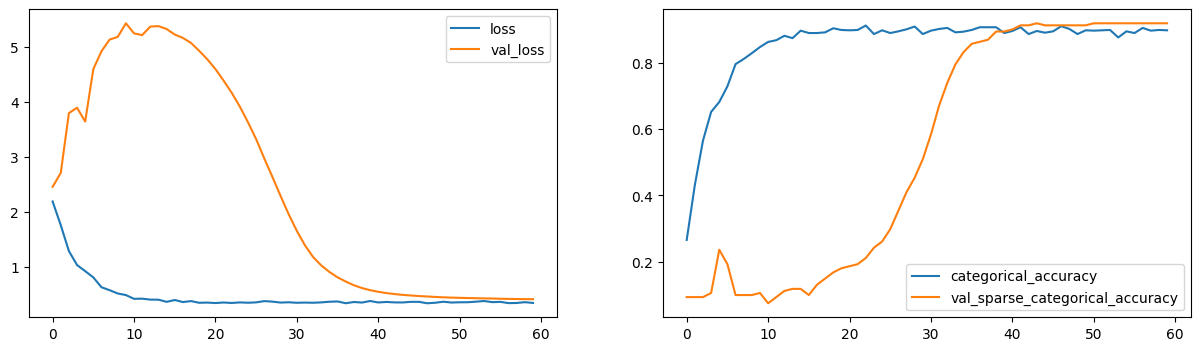

In [ ]:
plot(model)

In [ ]:
cnn_ltc_5_model.evaluate(cnn_ltc_5.x_test, cnn_ltc_5.y_test, batch_size = 64)

10/10 [==============================] - 1s 81ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.8115


[0.6422476172447205, 0.811475396156311]

# We can see that dropout really works but our test score didn't increased. Lets decrease dropout a bit and increase number of parameters in Dense layer and LTC

In [ ]:
class CNN_LTC_6():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        #model.add(Dense(dense_neurons,activation='relu'))
        #model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc_6 = CNN_LTC_6()
cnn_ltc_6.init()
cnn_ltc_6.create_data()
cnn_ltc_6_model = cnn_ltc_6.define_model(ncp_neurons=128,dense_neurons=64,dropout=0.15)
cnn_ltc_6_model.summary()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_338 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_339 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_340 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_341 (Time  (None, 28, 14, 

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_6.train_model(cnn_ltc_6_model)

Epoch 1/60
16/16 [==============================] - 25s 489ms/step - loss: 2.1887 - sparse_categorical_accuracy: 0.2791 - val_loss: 2.6104 - val_sparse_categorical_accuracy: 0.0373 - lr: 0.0100
Epoch 2/60
16/16 [==============================] - 11s 702ms/step - loss: 1.6257 - sparse_categorical_accuracy: 0.4583 - val_loss: 2.6970 - val_sparse_categorical_accuracy: 0.2547 - lr: 0.0100
Epoch 3/60
16/16 [==============================] - 10s 657ms/step - loss: 1.2255 - sparse_categorical_accuracy: 0.5994 - val_loss: 3.4313 - val_sparse_categorical_accuracy: 0.2298 - lr: 0.0100
Epoch 4/60
16/16 [==============================] - 7s 409ms/step - loss: 0.9149 - sparse_categorical_accuracy: 0.7302 - val_loss: 4.3988 - val_sparse_categorical_accuracy: 0.1677 - lr: 0.0100
Epoch 5/60
16/16 [==============================] - 7s 404ms/step - loss: 0.8112 - sparse_categorical_accuracy: 0.7322 - val_loss: 4.8481 - val_sparse_categorical_accuracy: 0.1988 - lr: 0.0100
Epoch 6/60
16/16 [==============

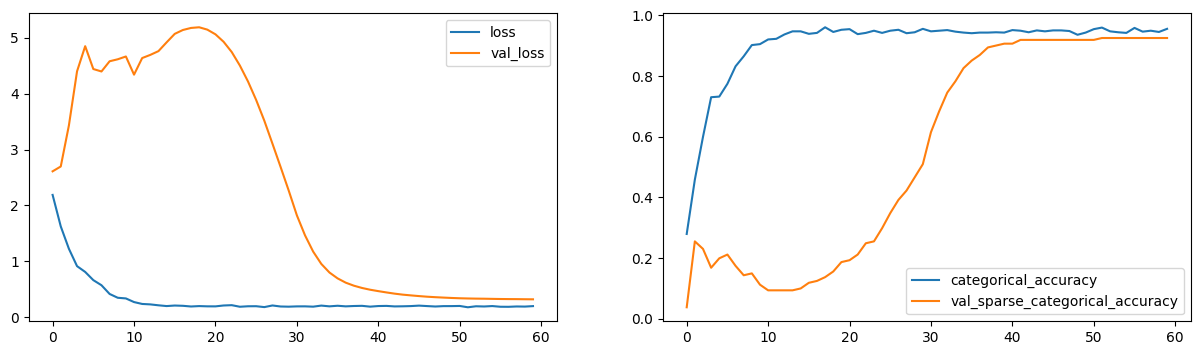

In [ ]:
plot(model)

In [ ]:
cnn_ltc_6_model.evaluate(cnn_ltc_6.x_test, cnn_ltc_6.y_test, batch_size = 64)

10/10 [==============================] - 1s 67ms/step - loss: 0.5519 - sparse_categorical_accuracy: 0.8180


[0.5519356727600098, 0.8180328011512756]

# Test score is still not good, as it could be. Lets try lower dropout layers, add Dense and change NCP to sparse connection in LTC

In [ ]:
class CNN_LTC_7():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = wirings.Random(ncp_neurons, self.num_classes,sparsity_level=0.75)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dense(dense_neurons, activation='relu'))

        model.add(LTC(self.wiring, return_sequences=False))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc_7 = CNN_LTC_7()
cnn_ltc_7.init()
cnn_ltc_7.create_data()
cnn_ltc_7_model = cnn_ltc_7.define_model(ncp_neurons=128,dense_neurons=64,dropout=0.15)
cnn_ltc_7_model.summary()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_364 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_365 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_366 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_367 (Time  (None, 28, 14, 

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_7.train_model(cnn_ltc_7_model)

Epoch 1/60
16/16 [==============================] - 21s 501ms/step - loss: 2.1634 - sparse_categorical_accuracy: 0.2812 - val_loss: 2.5875 - val_sparse_categorical_accuracy: 0.0807 - lr: 0.0100
Epoch 2/60
16/16 [==============================] - 6s 381ms/step - loss: 1.6931 - sparse_categorical_accuracy: 0.4243 - val_loss: 3.0443 - val_sparse_categorical_accuracy: 0.1491 - lr: 0.0100
Epoch 3/60
16/16 [==============================] - 7s 443ms/step - loss: 1.3336 - sparse_categorical_accuracy: 0.5561 - val_loss: 3.3850 - val_sparse_categorical_accuracy: 0.1615 - lr: 0.0100
Epoch 4/60
16/16 [==============================] - 6s 402ms/step - loss: 1.0743 - sparse_categorical_accuracy: 0.6612 - val_loss: 4.1299 - val_sparse_categorical_accuracy: 0.1677 - lr: 0.0100
Epoch 5/60
16/16 [==============================] - 7s 418ms/step - loss: 0.9166 - sparse_categorical_accuracy: 0.7065 - val_loss: 4.0844 - val_sparse_categorical_accuracy: 0.1180 - lr: 0.0100
Epoch 6/60
16/16 [================

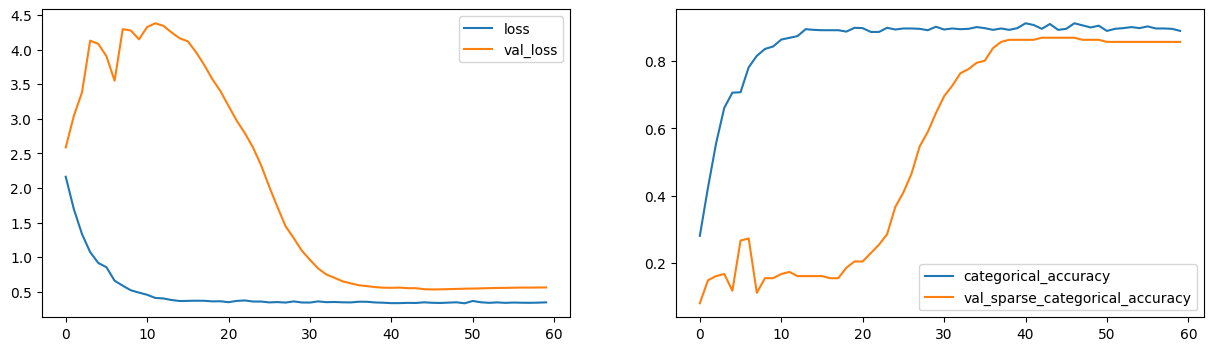

In [ ]:
plot(model)

In [ ]:
cnn_ltc_7_model.evaluate(cnn_ltc_7.x_test, cnn_ltc_7.y_test, batch_size = 64)

10/10 [==============================] - 1s 66ms/step - loss: 0.7073 - sparse_categorical_accuracy: 0.7541


[0.7072713375091553, 0.7540983557701111]

# We can see significant downgrade :( Seems like Sparse connection is much worse that NCP

# Lets try the best model we had and change NCP connection to Full conection and try it.

In [ ]:
class CNN_LTC_8():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = wirings.FullyConnected(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc_8 = CNN_LTC_8()
cnn_ltc_8.init()
cnn_ltc_8.create_data()
cnn_ltc_8_model = cnn_ltc_8.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.1)
cnn_ltc_8_model.summary()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_377 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_378 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_379 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_380 (Time  (None, 28, 14, 

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_8.train_model(cnn_ltc_8_model)

Epoch 1/60
16/16 [==============================] - 28s 482ms/step - loss: 2.1243 - sparse_categorical_accuracy: 0.3244 - val_loss: 2.5094 - val_sparse_categorical_accuracy: 0.0870 - lr: 0.0100
Epoch 2/60
16/16 [==============================] - 6s 356ms/step - loss: 1.6681 - sparse_categorical_accuracy: 0.4253 - val_loss: 3.0553 - val_sparse_categorical_accuracy: 0.0932 - lr: 0.0100
Epoch 3/60
16/16 [==============================] - 5s 286ms/step - loss: 1.3771 - sparse_categorical_accuracy: 0.5232 - val_loss: 3.6903 - val_sparse_categorical_accuracy: 0.0870 - lr: 0.0100
Epoch 4/60
16/16 [==============================] - 5s 345ms/step - loss: 1.2519 - sparse_categorical_accuracy: 0.5613 - val_loss: 3.4372 - val_sparse_categorical_accuracy: 0.1677 - lr: 0.0100
Epoch 5/60
16/16 [==============================] - 5s 297ms/step - loss: 1.0705 - sparse_categorical_accuracy: 0.6179 - val_loss: 3.2679 - val_sparse_categorical_accuracy: 0.2174 - lr: 0.0100
Epoch 6/60
16/16 [================

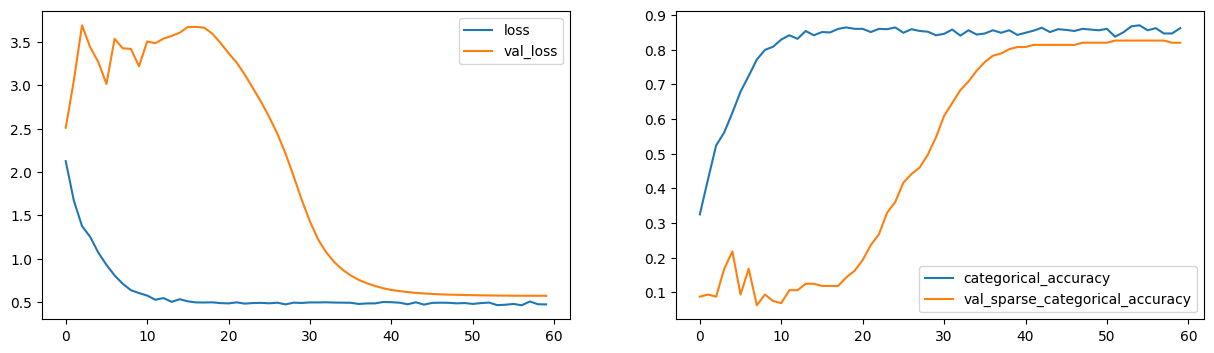

In [ ]:
plot(model)

In [ ]:
cnn_ltc_8_model.evaluate(cnn_ltc_8.x_test, cnn_ltc_8.y_test, batch_size = 64)

10/10 [==============================] - 0s 37ms/step - loss: 0.7228 - sparse_categorical_accuracy: 0.7459


[0.7227660417556763, 0.7459016442298889]

# Still NCP is much better than sparse or FC

# Lets try our best model on other dataset

In [ ]:
class CNN_LTC_9():

    def init(self):
        self.data_flag = 'fracturemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 3
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc_9 = CNN_LTC_9()
cnn_ltc_9.init()
cnn_ltc_9.create_data()
cnn_ltc_9_model = cnn_ltc_9.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.1)
cnn_ltc_9_model.summary()

100%|██████████| 3278419/3278419 [00:01<00:00, 2743513.79it/s]


Using downloaded and verified file: /root/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /root/.medmnist/fracturemnist3d.npz
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_390 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_391 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_392 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_393 (Time  (None, 28, 14, 14, 32)    4640      
 Distributed)                            

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc_9.train_model(cnn_ltc_9_model)

Epoch 1/60
17/17 [==============================] - 24s 639ms/step - loss: 1.0480 - sparse_categorical_accuracy: 0.4586 - val_loss: 1.0591 - val_sparse_categorical_accuracy: 0.4078 - lr: 0.0100
Epoch 2/60
17/17 [==============================] - 5s 292ms/step - loss: 1.0231 - sparse_categorical_accuracy: 0.4547 - val_loss: 1.0795 - val_sparse_categorical_accuracy: 0.3883 - lr: 0.0100
Epoch 3/60
17/17 [==============================] - 7s 417ms/step - loss: 0.9984 - sparse_categorical_accuracy: 0.5161 - val_loss: 1.0894 - val_sparse_categorical_accuracy: 0.3883 - lr: 0.0100
Epoch 4/60
17/17 [==============================] - 5s 295ms/step - loss: 0.9943 - sparse_categorical_accuracy: 0.4966 - val_loss: 1.0755 - val_sparse_categorical_accuracy: 0.3883 - lr: 0.0100
Epoch 5/60
17/17 [==============================] - 5s 296ms/step - loss: 0.9794 - sparse_categorical_accuracy: 0.5385 - val_loss: 1.0967 - val_sparse_categorical_accuracy: 0.3883 - lr: 0.0100
Epoch 6/60
17/17 [================

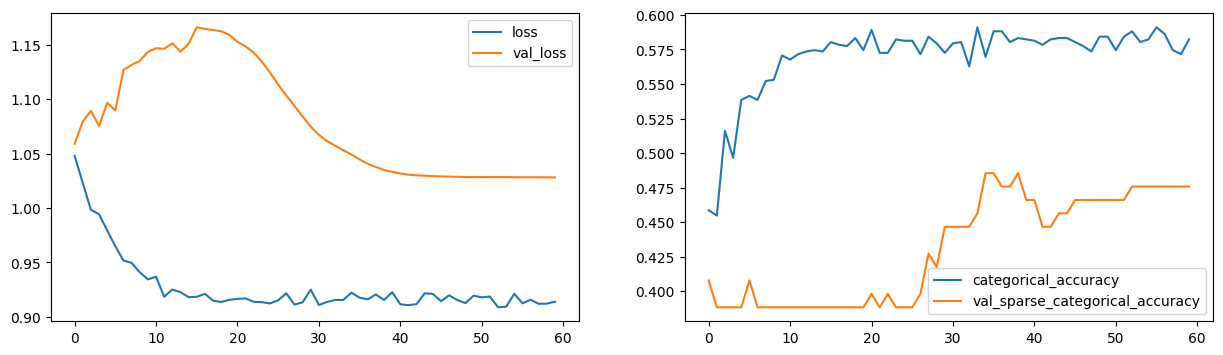

In [ ]:
plot(model)

In [ ]:
cnn_ltc_9_model.evaluate(cnn_ltc_9.x_test, cnn_ltc_9.y_test, batch_size = 64)

4/4 [==============================] - 1s 190ms/step - loss: 0.9957 - sparse_categorical_accuracy: 0.5292


[0.9957317113876343, 0.5291666388511658]

# COOL! THE BEST ACCURACY ON BENCHMARK!

# Lets score on other datasets also. AdrenalMnist

In [4]:
class CNN_LTC_9():

    def init(self):
        self.data_flag = 'adrenalmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [5]:
cnn_ltc_9 = CNN_LTC_9()
cnn_ltc_9.init()
cnn_ltc_9.create_data()
cnn_ltc_9_model = cnn_ltc_9.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.1)
cnn_ltc_9_model.summary()

100%|██████████| 276833/276833 [00:00<00:00, 399252.66it/s]


Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 28, 28, 28, 16)    160       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 28, 28, 28, 16)    64        
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 28, 14, 14, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 28, 14, 14, 32)    4640      
 stributed)                                   

In [9]:
#with tf.device('/device:GPU:0'):
#    model = cnn_ltc_9.train_model(cnn_ltc_9_model)

In [8]:
cnn_ltc_9_model.evaluate(cnn_ltc_9.x_test, cnn_ltc_9.y_test, batch_size = 64)

5/5 [==============================] - 1s 139ms/step - loss: 0.5420 - sparse_categorical_accuracy: 0.7685


[0.5419816374778748, 0.7684563994407654]

# VesselMnist

In [10]:
class CNN_LTC_9():

    def init(self):
        self.data_flag = 'vesselmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [11]:
cnn_ltc_9 = CNN_LTC_9()
cnn_ltc_9.init()
cnn_ltc_9.create_data()
cnn_ltc_9_model = cnn_ltc_9.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.1)
cnn_ltc_9_model.summary()

100%|██████████| 398349/398349 [00:00<00:00, 593668.26it/s]


Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, 28, 28, 28, 16)    160       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 28, 28, 28, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 28, 14, 14, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 28, 14, 14, 32)    4640      
 istributed)                                  

In [18]:
#with tf.device('/device:GPU:0'):
#    model = cnn_ltc_9.train_model(cnn_ltc_9_model)

In [13]:
cnn_ltc_9_model.evaluate(cnn_ltc_9.x_test, cnn_ltc_9.y_test, batch_size = 64)

6/6 [==============================] - 1s 142ms/step - loss: 0.3370 - sparse_categorical_accuracy: 0.8953


[0.33697769045829773, 0.8952879309654236]

# SynapseMNIST

In [19]:
class CNN_LTC_9():

    def init(self):
        self.data_flag = 'synapsemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.frames_to_sample = 28
        self.batch_size = 64
        self.num_epochs = 60
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []



    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.00005)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [36]:
cnn_ltc_9 = CNN_LTC_9()
cnn_ltc_9.init()
cnn_ltc_9.create_data()
cnn_ltc_9_model = cnn_ltc_9.define_model(ncp_neurons=64,dense_neurons=32,dropout=0.35)
cnn_ltc_9_model.summary()

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_104 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_105 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_106 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_107 (Time  (None, 28,

In [40]:
#with tf.device('/device:GPU:0'):
#    model = cnn_ltc_9.train_model(cnn_ltc_9_model)

In [39]:
cnn_ltc_9_model.evaluate(cnn_ltc_9.x_test, cnn_ltc_9.y_test, batch_size = 64)

6/6 [==============================] - 0s 47ms/step - loss: 0.6185 - sparse_categorical_accuracy: 0.7188


[0.6185271143913269, 0.71875]